# Sistemas Inteligentes: Trabajo práctico 3

## Integrantes

* **BARAFANI**, Facundo
* ***ROJAS**, Juan Pablo

## Consigna

Entrenar algunas de las redes anteriores para otro conjunto de datos.

Optamos por entrenar una RNN usando YOLO, para la detección de barbijo en el rostro haciendo uso del siguiente dataset: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

# Importa librerias

Comenzamos importando librerias que nos van a ser de utilidad para poder importar, manipular y graficar algunos datos.

In [1]:
import pandas as pd  # Importa la librería pandas para el manejo de datos tabulares
import numpy as np  # Importa la librería numpy para operaciones matemáticas en arrays multidimensionales
import matplotlib.pyplot as plt  # Importa la librería matplotlib para la visualización de gráficos
import seaborn as sns  # Importa la librería seaborn para la mejora de la visualización de datos
import os  # Importa la librería os para interactuar con el sistema operativo
import cv2  # Importa la librería cv2 de OpenCV para el procesamiento de imágenes y videos
import PIL  # Importa la librería PIL para manipular imágenes en Python
import xml.etree.ElementTree as ET  # Importa el módulo ElementTree de la librería xml para trabajar con XML
import glob  # Importa la librería glob para buscar archivos que coincidan con un patrón
import time  # Importa la librería time para trabajar con operaciones relacionadas con el tiempo
import datetime  # Importa la librería datetime para trabajar con fechas y horas

# Carga de imagenes

Procedemos a cargar las imagenes del dataset

In [2]:
img_dir = './kaggle/input/face-mask-detection/images'
annotation_dir = './kaggle/input/face-mask-detection/annotations'

input_dir = './kaggle/input/face-mask-detection'
output_dir = './kaggle/working/'

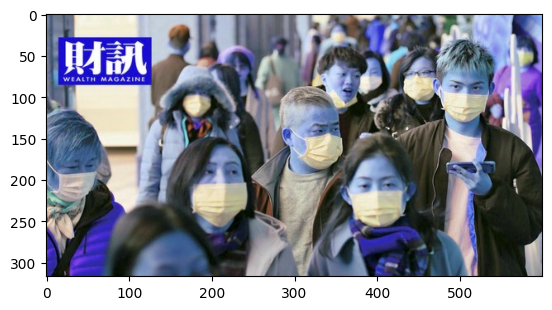

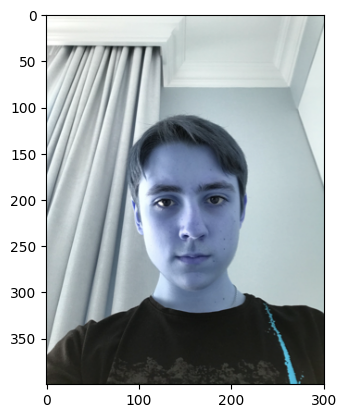

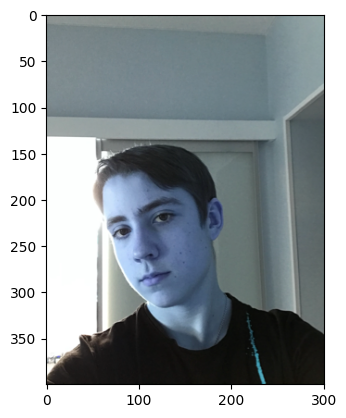

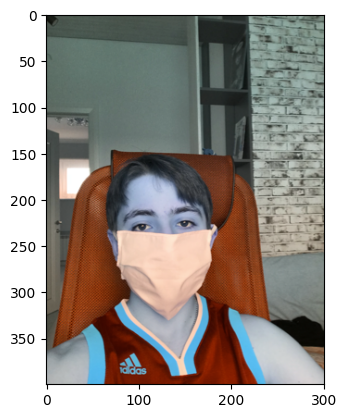

In [3]:
# Get the directory of the current Jupyter Notebook file
current_file_path = os.path.realpath('__file__')
current_directory = os.path.dirname(current_file_path)

os.chdir(current_directory)

os.listdir(img_dir)
for idx, image in enumerate(os.listdir(img_dir)):
    img = cv2.imread(os.path.join(img_dir, image), 1)
    plt.imshow(img)
    plt.show()
    
    if idx == 3:
        break

In [4]:
img_file_path = []
for img in os.listdir(img_dir):
    image  = cv2.imread(os.path.join(img_dir, img), 0)
    img_file_path.append(f'{img}')

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [5]:
len(img_file_path)

853

In [6]:
for i in glob.glob(annotation_dir+'/*.xml'):
    print(i.split('/')[-1][0:-4])
    
    break

maksssksksss299


# Generación de etiquetas (labels)

In [7]:
df = { 'name': [],
        'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

for idx, anno in enumerate(glob.glob(annotation_dir + '/*.xml')):
    trees = ET.parse(anno)
    
    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)
               
        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width = int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))
                    
        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]] 
                    df['name'] += [anno.split('/')[-1][0:-4]]
                    
                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]
                            
                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

# Creación del dataframe

In [8]:
df1 = pd.DataFrame(df)
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,maksssksksss299,without_mask,301,400,62,194,160,320
1,maksssksksss528,without_mask,301,400,43,169,149,308
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304
3,maksssksksss514,with_mask,400,267,28,78,43,99
4,maksssksksss514,with_mask,400,267,160,66,176,83


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4072 non-null   object
 1   label   4072 non-null   object
 2   width   4072 non-null   int64 
 3   height  4072 non-null   int64 
 4   xmin    4072 non-null   int64 
 5   ymin    4072 non-null   int64 
 6   xmax    4072 non-null   int64 
 7   ymax    4072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 254.6+ KB


In [10]:
df1['label'].value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

In [11]:
label_map = { 'without_mask': 0,
            'with_mask': 1,
            'mask_weared_incorrect': 2}

df1['class'] = df1['label'].map(label_map)

In [12]:
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss299,without_mask,301,400,62,194,160,320,0
1,maksssksksss528,without_mask,301,400,43,169,149,308,0
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304,2
3,maksssksksss514,with_mask,400,267,28,78,43,99,1
4,maksssksksss514,with_mask,400,267,160,66,176,83,1


# Preparación de la estructura para el entrenamiento del modelo YoloV5

## Train test split

In [13]:
0.25 * 4072

1018.0

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(img_file_path, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)

In [15]:
print('='*50)
print('Length of train directory: {}'.format(len(train)))
print('='*50)
print('Length of validation directory: {}'.format(len(val)))
print('='*50)
print('Length of test directory: {}'.format(len(test)))
print('='*50)

Length of train directory: 579
Length of validation directory: 103
Length of test directory: 171


## Creación de directorio para YoloV5

In [16]:
os.chdir(current_directory)
os.chdir('./kaggle/working')

In [17]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt
!pip install utils

Cloning into 'yolov5'...
remote: Enumerating objects: 15978, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 15978 (delta 89), reused 110 (delta 70), pack-reused 15831
Receiving objects: 100% (15978/15978), 14.54 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (10963/10963), done.
/Users/facundobarafani/Documents/UCC/sistemas_inteligentes/tp_final/kaggle/working/yolov5
You should consider upgrading via the '/Users/facundobarafani/Documents/UCC/sistemas_inteligentes/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/facundobarafani/Documents/UCC/sistemas_inteligentes/venv/bin/python -m pip install --upgrade pip' command.


In [18]:
# create a separate folder structure for train, validation and test image and validation files
os.chdir(current_directory)
os.getcwd()
os.chdir('./kaggle/working')
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')

In [19]:
os.chdir(current_directory)
os.getcwd()
def copy_image_file(image_items, folder_name):
    
    for image in image_items:
        img = PIL.Image.open(f'{img_dir}/{image}')
        img1 = img.resize((640, 480))
        _ = img1.save(f'{output_dir}/yolov5/data/{folder_name}/images/{image}')

copy_image_file(train, 'train')
copy_image_file(val, 'val')
copy_image_file(test, 'test')

In [20]:
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss299,without_mask,301,400,62,194,160,320,0
1,maksssksksss528,without_mask,301,400,43,169,149,308,0
2,maksssksksss272,mask_weared_incorrect,275,400,48,107,218,304,2
3,maksssksksss514,with_mask,400,267,28,78,43,99,1
4,maksssksksss514,with_mask,400,267,160,66,176,83,1


Copiamos los labels en la carpeta que creamos para el yoloV5

Resize the annotation box, because here change the image size so we can change the annotation box size. and find the center of the coordinates

x = (new_x/older_x)* x

In [21]:
df1['xmin'] = (640/df1['width']) * df1['xmin']
df1['ymin'] = (480/df1['height']) * df1['ymin']
df1['xmax'] = (640/df1['width']) * df1['xmax']
df1['ymax'] = (480/df1['height']) * df1['ymax']
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss299,without_mask,301,400,131.827243,232.800000,340.199336,384.000000,0
1,maksssksksss528,without_mask,301,400,91.428571,202.800000,316.810631,369.600000,0
2,maksssksksss272,mask_weared_incorrect,275,400,111.709091,128.400000,507.345455,364.800000,2
3,maksssksksss514,with_mask,400,267,44.800000,140.224719,68.800000,177.977528,1
4,maksssksksss514,with_mask,400,267,256.000000,118.651685,281.600000,149.213483,1


In [22]:
df1[['xmin', 'ymin', 'xmax', 'ymax']] = df1[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')

calculate the center of x and y, and mind the mid point of width and height of annotaion box. Here the variables are x, y, w, h

--> x = (x1+x2)(2w) --> y = (y1+y2)(2h) --> mid_w = (x2-x1)/(w) --> mid_h = (y2-y1)/(h)

In [23]:
WIDTH = 640
HEIGHT = 480

In [24]:
df1['x_center'] = (df1['xmin']+df1['xmax'])/(2*WIDTH)
df1['y_center'] = (df1['ymin']+df1['ymax'])/(2*HEIGHT)
df1['box_width'] = (df1['xmax']-df1['xmin'])/ WIDTH
df1['box_height'] = (df1['ymax']-df1['ymin'])/ HEIGHT

In [25]:
df1.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,maksssksksss299,without_mask,301,400,131,232,340,384,0,0.367969,0.641667,0.326562,0.316667
1,maksssksksss528,without_mask,301,400,91,202,316,369,0,0.317969,0.594792,0.351562,0.347917
2,maksssksksss272,mask_weared_incorrect,275,400,111,128,507,364,2,0.482812,0.512500,0.618750,0.491667
3,maksssksksss514,with_mask,400,267,44,140,68,177,1,0.087500,0.330208,0.037500,0.077083
4,maksssksksss514,with_mask,400,267,256,118,281,149,1,0.419531,0.278125,0.039062,0.064583


In [26]:
df1['class'].nunique()

3

In [27]:
df1 = df1.astype(str)

In [28]:
df1.name

0       maksssksksss299
1       maksssksksss528
2       maksssksksss272
3       maksssksksss514
4       maksssksksss514
             ...       
4067    maksssksksss294
4068    maksssksksss294
4069    maksssksksss294
4070    maksssksksss294
4071    maksssksksss294
Name: name, Length: 4072, dtype: object

In [29]:
os.chdir(current_directory)
os.getcwd()

def copy_label(label_items, folder_name):
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df1[df1.name == name]

        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

        text = "\n".join(box_list)
        with open(f'{output_dir}/yolov5/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)

In [30]:
copy_label(train, 'train')
copy_label(val, 'val')
copy_label(test, 'test')

In [31]:
os.chdir(current_directory)
os.getcwd()

os.chdir('./kaggle/working/yolov5/data/train/labels')

In [32]:
cat maksssksksss0.txt 

0 0.1828125 0.33645833333333336 0.059375 0.10208333333333333
1 0.40078125 0.33229166666666665 0.0796875 0.11875
0 0.66875 0.3145833333333333 0.06875 0.1375

Configuración de YoloV5

In [33]:
os.chdir(current_directory)

os.chdir('./kaggle/working/yolov5')

In [34]:
from IPython.display import Image, clear_output
import torch 
import tensorflow
from yolov5 import utils

In [35]:
display = utils.notebook_init()

YOLOv5 🚀 2023-6-11 Python-3.9.6 torch-2.0.1 CPU


Setup complete ✅ (10 CPUs, 16.0 GB RAM, 162.6/460.4 GB disk)


In [36]:
# Configure .yaml file 
yaml_file = """train: data/train/images
val: data/val/images
                
nc: 3
names: [without_mask, with_mask, mask_weared_incorrect]"""

with open('data/data.yaml', 'w') as f:
    f.write(yaml_file)

In [37]:
%cat data/data.yaml

train: data/train/images
val: data/val/images
                
nc: 3
names: [without_mask, with_mask, mask_weared_incorrect]

In [38]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [41]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

# Entrenamos el modelo YoloV5 usando el dataset

In [84]:
start = time.time()

!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights yolov5s.pt --name yolov5s_results --cache

WARNING  user config directory is not writeable, defaulting to '/tmp/Ultralytics'.
train: weights=yolov5s.pt, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-178-ga199480 Python-3.9.6 torch-2.0.1 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj

In [85]:
!python detect.py --source 0 --img 640 --data data/data.yaml --weights ./runs/train/yolov5s_results2/weights/best.pt --conf 0.25

detect: weights=['./runs/train/yolov5s_results2/weights/best.pt'], source=0, data=data/data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-178-ga199480 Python-3.9.6 torch-2.0.1 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
1/1: 0...  Success (inf frames 1920x1080 at 30.00 FPS)

0: 384x640 1 with_mask, 65.7ms
0: 384x640 1 without_mask, 1 with_mask, 60.6ms
0: 384x640 1 without_mask, 1 with_mask, 59.0ms
0: 384x640 1 without_mask, 1 with_mask, 58.5ms
0: 384x640 1 without_mask, 59.5ms
0: 384x640 1 without_mask, 57.4ms
0: 384x640 1 without_mask, 57.6ms
0: 384x640 1 without_mask, 60.2ms
0: 384x640 1 without_mas